In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import load_excel, load_odin_as_ml_dataset, plot_confusion_matrix

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [ ]:
# Here just in case
# year = 2022
# odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
# df = load_excel(odin_excel_path)

Loaded file from CSV


Loaded file from CSV
Drop Column AantRitVertLoc not in dataframe
Categorical Column Wogem not in dataframe
Categorical Column RDHalteA not in dataframe
Categorical Column AutoHhl not in dataframe
Categorical Column KGewitchPa1 not in dataframe
Categorical Column AantOVVPl not in dataframe
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     34067
        True       1.00      0.98      0.99      5944

    accuracy                           1.00     40011
   macro avg       1.00      0.99      0.99     40011
weighted avg       1.00      1.00      1.00     40011

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     34067
        True       1.00      0.98      0.99      5944

    accuracy                           1.00     40011
   macro avg       1.00      0.99      0.99     40011
weighted avg       1.00      1.00      1.00     40011



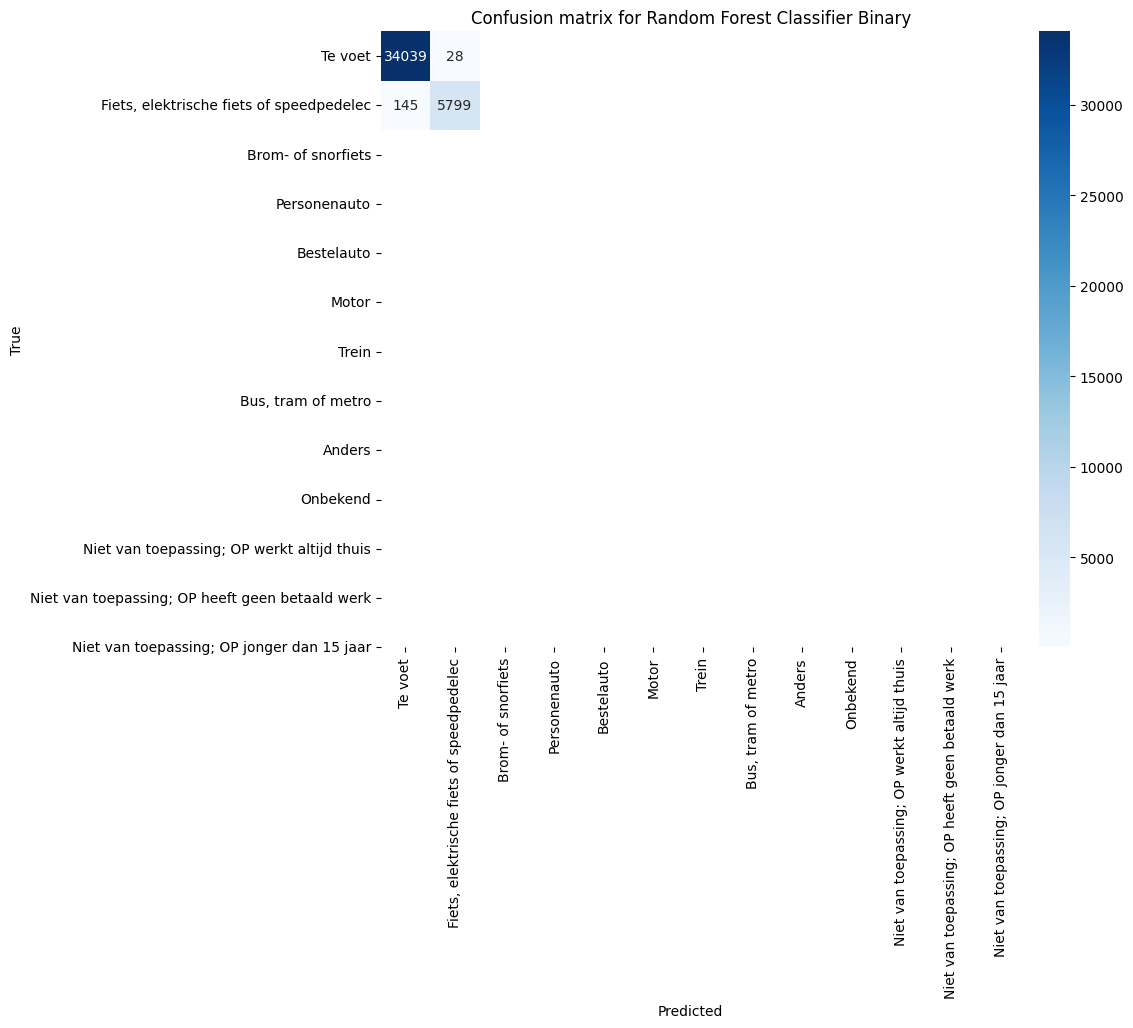

In [ ]:
# Use a random forest classifier as an example
X_train, X_test, y_train, y_test = load_odin_as_ml_dataset(year=2022,)

model = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

In [5]:

print(classification_report(y_test, y_pred))
print(cm)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     34067
        True       1.00      0.98      0.99      5944

    accuracy                           1.00     40011
   macro avg       1.00      0.99      0.99     40011
weighted avg       1.00      1.00      1.00     40011

[[34039    28]
 [  145  5799]]


In [8]:
X_train, X_test, y_train, y_test = load_odin_as_ml_dataset(year=2022, target_val=None)

labels = [
    "Te voet",
    "Fiets, elektrische fiets of speedpedelec",
    "Brom- of snorfiets",
    "Personenauto",
    "Bestelauto",
    "Motor",
    "Trein",
    "Bus, tram of metro",
    "Anders",
    "Onbekend",
    "Niet van toepassing; OP werkt altijd thuis",
    "Niet van toepassing; OP heeft geen betaald werk",
    "Niet van toepassing; OP jonger dan 15 jaar"
]

model = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


Loaded file from CSV
Drop Column AantRitVertLoc not in dataframe
Categorical Column Wogem not in dataframe
Categorical Column RDHalteA not in dataframe
Categorical Column AutoHhl not in dataframe
Categorical Column KGewitchPa1 not in dataframe
Categorical Column AantOVVPl not in dataframe
              precision    recall  f1-score   support

           1       0.99      0.91      0.95       734
           2       0.97      0.99      0.98      5944
           3       1.00      0.91      0.95       332
           4       0.99      0.99      0.99     10127
           5       0.99      0.89      0.94       615
           6       1.00      0.88      0.93       105
           7       0.98      0.99      0.99      2165
           8       1.00      0.93      0.96      1029
           9       1.00      0.88      0.94       157
          10       1.00      0.99      0.99       517
          11       0.98      0.88      0.93       819
          12       0.99      1.00      0.99     13890
       

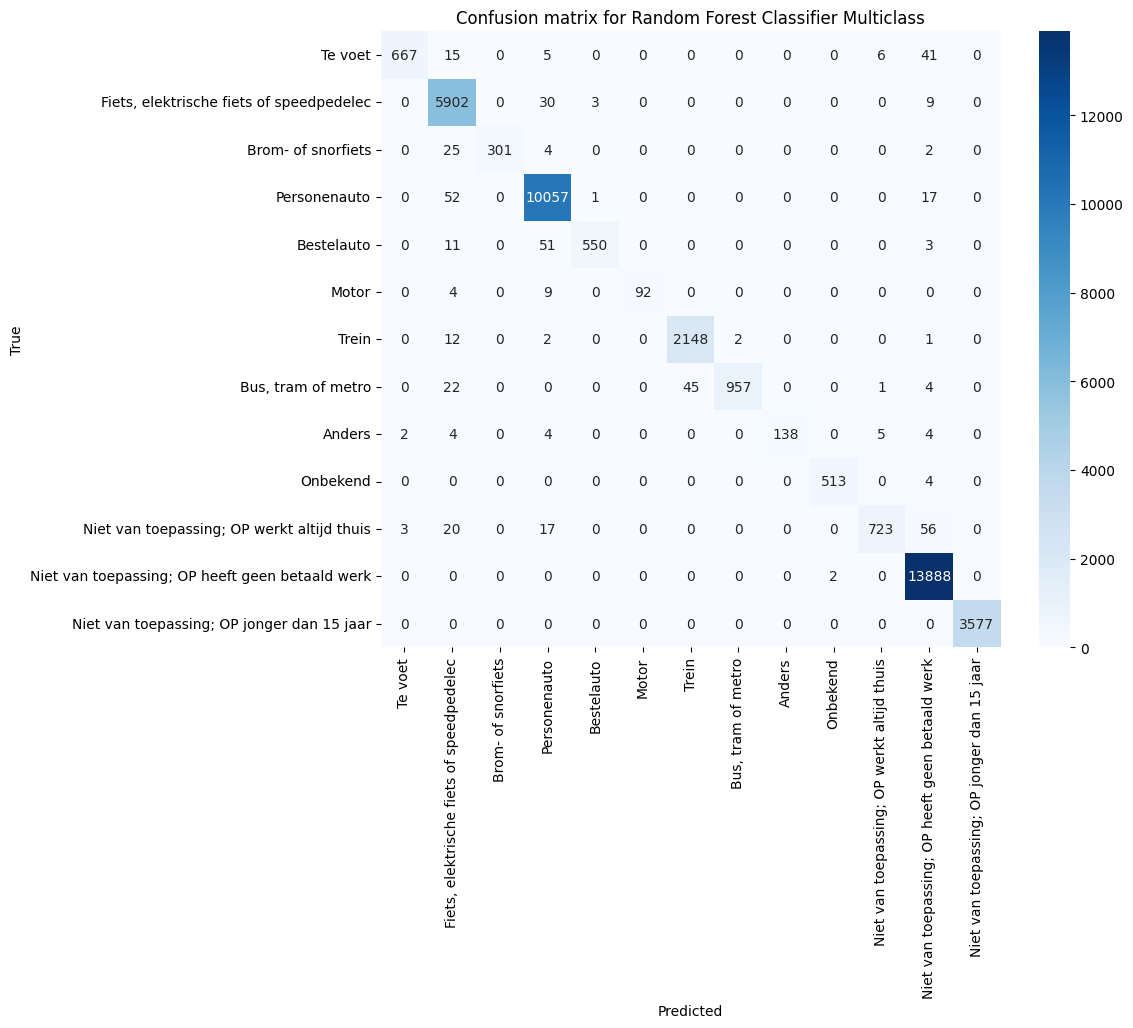

In [9]:
plot_confusion_matrix(
    cm=cm,
    labels=labels,
    title="Confusion matrix for Random Forest Classifier Multiclass",
    show=True
)